# Algorithmic Tokenizer 
Takes Segmentation Masks and Returns a Text-based token representation of the frame and its masks

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import pickle
import time
from IPython.display import clear_output

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [2]:
def show_anns_reg(anns):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
# make a list of colors
def random_colors(N):
    np.random.seed(1)
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    colors = np.array([color])
    for i in range(N-1):
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        colors = np.concatenate([colors, [color]], axis=0)
    return colors

color_list = random_colors(100)

def show_mask(mask, ax, random_color=False, color=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color is not None:
        color = color
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [4]:
image_dir = '/home/yashas/Documents/thesis/segment-anything/test-images/traj0/images0/'
image_prefix = 'im_'
image_suffix = '.jpg'

In [5]:
big_plot_dim = 8

In [6]:
with open("total_masks_over_time.pkl", "rb") as f:
    total_masks_over_time = pickle.load(f)

print(total_masks_over_time.shape)

(47, 6, 480, 640)


In [7]:
curr_frame_num = 0
curr_frame = total_masks_over_time[curr_frame_num]
print(curr_frame.shape)

(6, 480, 640)


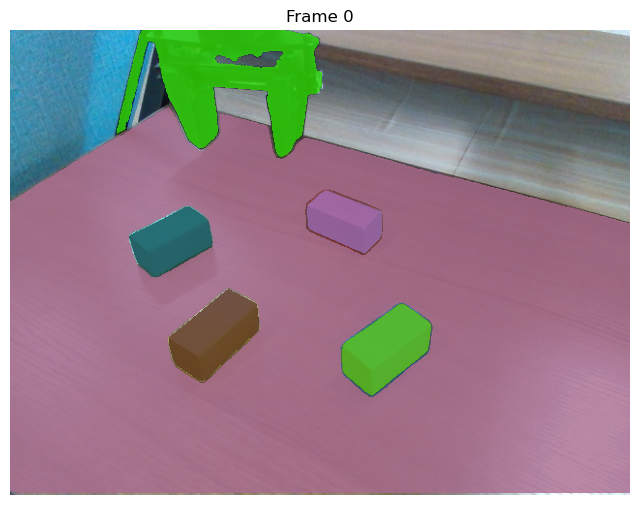

In [8]:
# Display the current frame and then the mask
image = cv2.imread(image_dir + image_prefix + str(curr_frame_num) + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.title('Frame ' + str(curr_frame_num))
plt.imshow(image)
for j in range(curr_frame.shape[0]):
    show_mask(curr_frame[j], plt.gca(), color=color_list[j])
plt.axis('off')
plt.show()


In [9]:
def find_centroid(mask):
    mask = mask.astype(np.uint8)
    M = cv2.moments(mask)
    if M["m00"] == 0:
        return np.array([0, 0])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return np.array([cX, cY])

In [10]:
# Testing the centroid function
centroids = []
for i in range(len(curr_frame)):
    centroid = find_centroid(curr_frame[i])
    centroids.append(centroid)

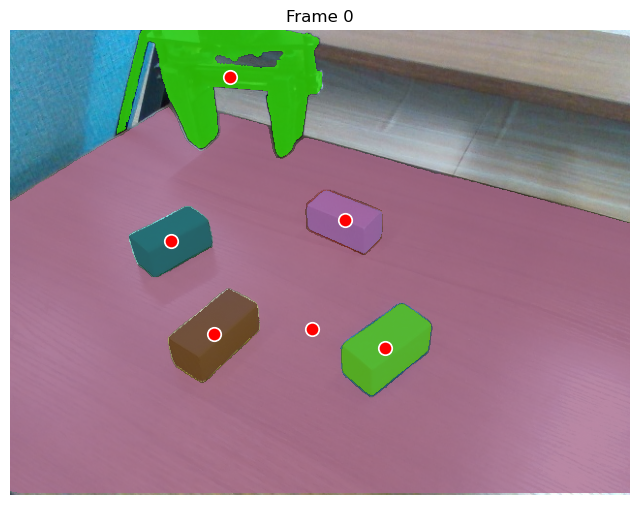

In [11]:
# Displaying the centroid on the image
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.title('Frame ' + str(curr_frame_num))
plt.imshow(image)
for j in range(curr_frame.shape[0]):
    show_mask(curr_frame[j], plt.gca(), color=color_list[j])
for j in range(len(centroids)):
    plt.scatter(centroids[j][0], centroids[j][1], color='red', marker='.', s=375, edgecolor='white', linewidth=1.25)
plt.axis('off')
plt.show()

In [12]:
# Raycast out from the centroid and find the distance to the outer border of the mask
# TODO: Implement logic for when centroid point is outside the mask- need to employ special logic in that case
def raycast(mask, point, angle, max_dist):
    furthest_dist = -1
    in_bounds = True
    for i in range(max_dist):
        x = int(point[0] + i * np.cos(angle))
        y = int(point[1] + i * np.sin(angle))
        if x < 0 or y < 0 or x >= mask.shape[1] or y >= mask.shape[0]:
            if in_bounds:
                furthest_dist = i
            return furthest_dist
        if not in_bounds and mask[y, x] == 1:
            in_bounds = True
        if in_bounds and mask[y, x] == 0:
            in_bounds = False
            furthest_dist = i
    return furthest_dist

Raycast distance for mask 0 is 45
Raycast distance for mask 1 is 43
Raycast distance for mask 2 is 43
Raycast distance for mask 3 is 39
Raycast distance for mask 4 is 105
Raycast distance for mask 5 is 312


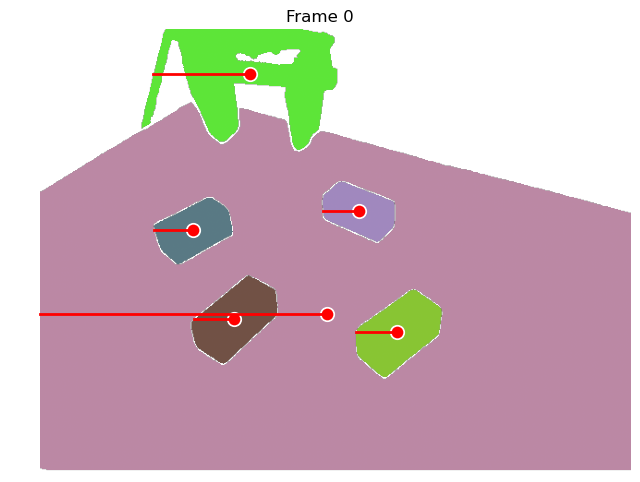

In [13]:
# Test the raycast function
angle = np.pi
max_dist = 400
raycast_distances = []
for i in range(len(centroids)):
    raycast_distance = raycast(curr_frame[i], centroids[i], angle, max_dist)
    raycast_distances.append(raycast_distance)
    print('Raycast distance for mask', i, 'is', raycast_distance)

# Displaying the raycast on the image
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.title('Frame ' + str(curr_frame_num))
# plt.imshow(image)
for j in range(curr_frame.shape[0]):
    show_mask(curr_frame[j], plt.gca(), color=color_list[j])
for j in range(len(centroids)):
    plt.scatter(centroids[j][0], centroids[j][1], color='red', marker='.', s=375, edgecolor='white', linewidth=1.25)
    plt.plot([centroids[j][0], centroids[j][0] + raycast_distances[j] * np.cos(angle)], [centroids[j][1], centroids[j][1] + raycast_distances[j] * np.sin(angle)], color='red', linestyle='-', linewidth=2)
plt.axis('off')
plt.show()

In [14]:
def tokenize_single_mask(mask, id, num_rays):
    # Find the centroid of the mask
    centroid = find_centroid(mask)
    # Tokenize the mask
    tokens = []
    tokens.append(str(id))
    tokens.append(centroid[0])
    tokens.append(centroid[1])
    for i in range(num_rays):
        angle = i * 2 * np.pi / num_rays
        raycast_distance = raycast(mask, centroid, angle, 400)
        tokens.append(raycast_distance)
    return tokens

In [15]:
# Test the tokenization function
num_rays = 50
tokens = tokenize_single_mask(curr_frame[0], 0, num_rays)
print('Tokens for mask 0:', tokens)

Tokens for mask 0: ['0', 387, 328, 45, 43, 39, 36, 34, 33, 31, 32, 31, 31, 33, 35, 38, 43, 47, 52, 50, 49, 49, 49, 50, 50, 48, 47, 46, 45, 42, 38, 34, 32, 30, 29, 29, 28, 29, 30, 32, 34, 37, 41, 48, 50, 49, 49, 50, 52, 54, 52, 49, 47]


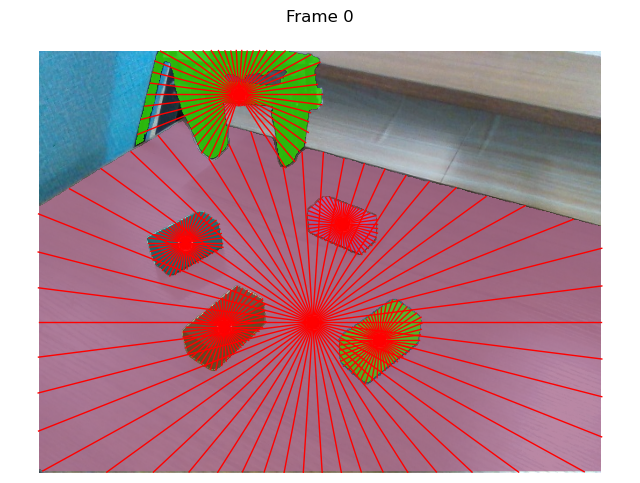

In [16]:
def tokenize_masks(masks):
    ret_tokens = []
    for i in range(len(masks)):
        tokens = tokenize_single_mask(masks[i], i, num_rays)
        ret_tokens.append(tokens)
        # print('Tokens for mask', i, ':', tokens)
    return ret_tokens

# Test the tokenization function
frame_tokens = tokenize_masks(curr_frame)

# Visualize frame_tokens
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.title('Frame ' + str(curr_frame_num))
plt.imshow(image)
for j in range(curr_frame.shape[0]):
    show_mask(curr_frame[j], plt.gca(), color=color_list[j])
for j in range(len(centroids)):
    plt.scatter(centroids[j][0], centroids[j][1], color='blue', marker='.', s=375, edgecolor='white', linewidth=1.25)
    for k in range(num_rays):
        plt.plot([centroids[j][0], centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays)], [centroids[j][1], centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays)], color='red', linestyle='-', linewidth=1)
plt.axis('off')
plt.show()

In [17]:
# Given a list of points that represent a polygon, write a function to convert it to a mask
def polygon_to_mask(polygon, width, height):
    mask = np.zeros((height, width))
    polygon = np.array(polygon, np.int32)
    mask = cv2.fillPoly(mask, [polygon], 1)
    return mask

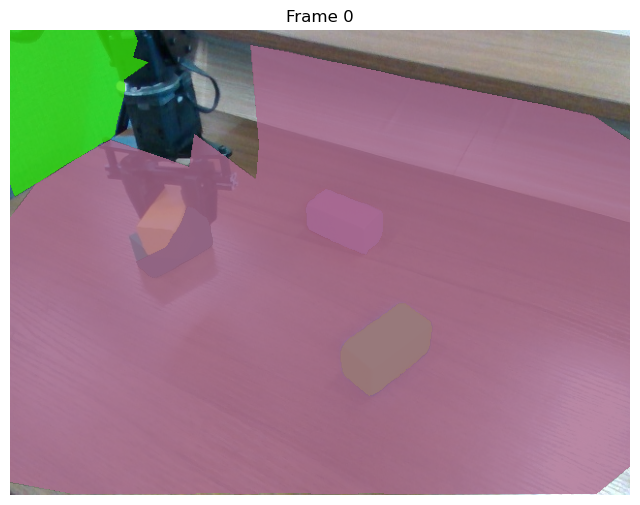

In [28]:
# Given a centroid and a list of radiused points and the height and width of the original image, reconstruct the mask, making sure all the points inside the polygon are filled in
def reconstruct_mask(centroid, radiused_points, width, height):
    mask = np.zeros((height, width))
    polygon_points = []
    for i in range(len(radiused_points)):
        angle = i * 2 * np.pi / len(radiused_points)
        polygon_points.append([int(centroid[0] + radiused_points[i] * np.cos(angle)), int(centroid[1] + radiused_points[i] * np.sin(angle))])

    mask = polygon_to_mask(polygon_points, width, height)
    return mask



# Test the reconstruction function
reconstructed_masks = []
for i in range(len(frame_tokens)):
    reconstructed_mask = reconstruct_mask(np.array([frame_tokens[i][1], frame_tokens[i][2]]), frame_tokens[i][3:], image.shape[1], image.shape[0])
    reconstructed_masks.append(reconstructed_mask)

# Visualize the reconstructed masks
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.title('Frame ' + str(curr_frame_num))
plt.imshow(image)
for j in range(len(reconstructed_masks)):
    show_mask(reconstructed_masks[j], plt.gca(), color=color_list[j])
plt.axis('off')
plt.show()

In [19]:
# Tokenize all frames and visualize the reconstructed masks as an animation
num_rays = 50
reconstructed_masks_over_time = []
for i in range(len(total_masks_over_time)):
    curr_frame = total_masks_over_time[i]
    print('Tokenizing frame', i)
    frame_tokens = tokenize_masks(curr_frame)
    reconstructed_masks = []
    for j in range(len(frame_tokens)):
        reconstructed_mask = reconstruct_mask(np.array([frame_tokens[j][1], frame_tokens[j][2]]), frame_tokens[j][3:], image.shape[1], image.shape[0])
        reconstructed_masks.append(reconstructed_mask)
    reconstructed_masks_over_time.append(reconstructed_masks)

Tokenizing frame 0
Tokenizing frame 1
Tokenizing frame 2
Tokenizing frame 3
Tokenizing frame 4
Tokenizing frame 5
Tokenizing frame 6
Tokenizing frame 7
Tokenizing frame 8
Tokenizing frame 9
Tokenizing frame 10
Tokenizing frame 11
Tokenizing frame 12
Tokenizing frame 13
Tokenizing frame 14
Tokenizing frame 15
Tokenizing frame 16
Tokenizing frame 17
Tokenizing frame 18
Tokenizing frame 19
Tokenizing frame 20
Tokenizing frame 21
Tokenizing frame 22
Tokenizing frame 23
Tokenizing frame 24
Tokenizing frame 25
Tokenizing frame 26
Tokenizing frame 27
Tokenizing frame 28
Tokenizing frame 29
Tokenizing frame 30
Tokenizing frame 31
Tokenizing frame 32
Tokenizing frame 33
Tokenizing frame 34
Tokenizing frame 35
Tokenizing frame 36
Tokenizing frame 37
Tokenizing frame 38
Tokenizing frame 39
Tokenizing frame 40
Tokenizing frame 41
Tokenizing frame 42
Tokenizing frame 43
Tokenizing frame 44
Tokenizing frame 45
Tokenizing frame 46


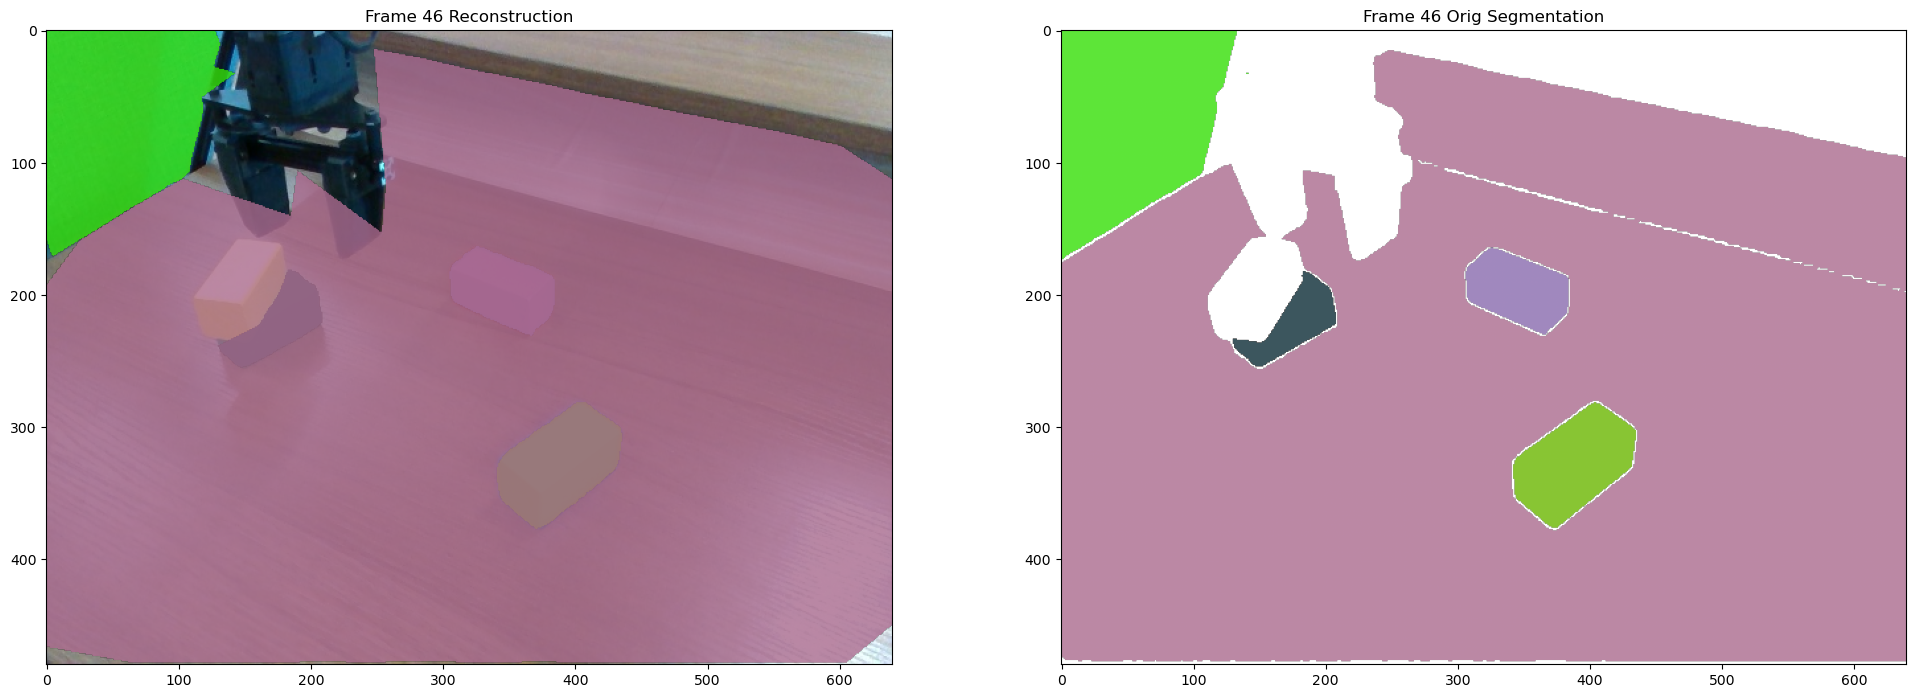

In [35]:
# Visualize the reconstructed masks over time compared to the original masks
for i in range(len(reconstructed_masks_over_time)):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2, figsize=(big_plot_dim*3, big_plot_dim*3))
    axs[0].set_title(f'Frame {i} Reconstruction')
    axs[0].imshow(image)
    for j in range(len(reconstructed_masks_over_time[i])):
        show_mask(reconstructed_masks_over_time[i][j], axs[0], color=color_list[j])
    # plt.axis('off')
    axs[1].set_title(f'Frame {i} Orig Segmentation')
    for j in range(total_masks_over_time[i].shape[0]):
        show_mask(total_masks_over_time[i][j], axs[1], color=color_list[j])
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)